In [2]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


2025-08-19 15:16:18.753 No runtime found, using MemoryCacheStorageManager
2025-08-19 15:16:18.757 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:16:18.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:16:18.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:16:18.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:16:19.274 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:16:19.275 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:16:19.276 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/tmp/ipython-input-2648171167.py:12: UserWarning: 

DeltaGenerator()

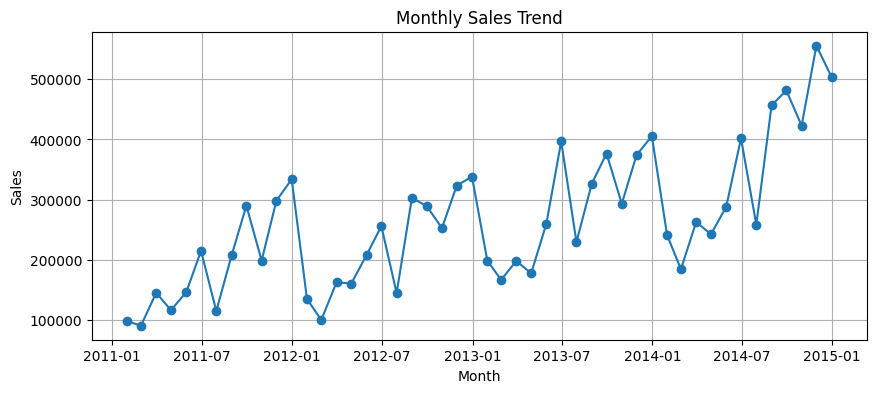

In [4]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # New: For outlier detection

# Step 1: Load, clean, and prepare the dataset
@st.cache_data
def load_data():
    # Load the CSV file
    df = pd.read_csv('Global_Superstore.csv', encoding='ISO-8859-1')

    # Convert 'Order Date' to datetime
    df['Order Date'] = pd.to_datetime(df['Order Date'])

    # Cleaning steps:
    # 1. Handle missing values
    df['Postal Code'] = df['Postal Code'].fillna('Unknown')
    if df.isnull().any().any():
        st.warning("Dataset had some missing values, handled where possible.")

    # 2. Remove duplicates
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['Order ID'])
    st.session_state['cleaning_summary'] = f"Removed {initial_rows - len(df)} duplicate rows."  # New: Store cleaning summary

    # 3. Handle invalid data
    df = df[df['Sales'] >= 0]

    # 4. New: Outlier detection for Sales and Profit (using IQR method)
    for col in ['Sales', 'Profit']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        initial_rows = len(df)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        st.session_state['cleaning_summary'] += f"\nRemoved {initial_rows - len(df)} outliers in {col}."

    # 5. Standardize strings
    categorical_cols = ['Region', 'Category', 'Sub-Category', 'Segment', 'Customer Name']
    for col in categorical_cols:
        df[col] = df[col].str.strip()

    # 6. Round numerical columns
    df['Sales'] = df['Sales'].round(2)
    df['Profit'] = df['Profit'].round(2)

    return df

# Initialize session state for cleaning summary if not exists
if 'cleaning_summary' not in st.session_state:
    st.session_state['cleaning_summary'] = ""

df = load_data()

# Step 2: Sidebar filters
st.sidebar.header("Filters")

# New: Date range filter
min_date = df['Order Date'].min().date()
max_date = df['Order Date'].max().date()
selected_dates = st.sidebar.date_input("Select Date Range", [min_date, max_date], min_value=min_date, max_value=max_date)

# Unique values for filters
regions = df['Region'].unique().tolist()
categories = df['Category'].unique().tolist()
sub_categories = df['Sub-Category'].unique().tolist()
segments = df['Segment'].unique().tolist()

# Filter widgets
selected_region = st.sidebar.multiselect("Select Region", options=regions, default=regions, key="region")
selected_category = st.sidebar.multiselect("Select Category", options=categories, default=categories, key="category")
selected_subcategory = st.sidebar.multiselect("Select Sub-Category", options=sub_categories, default=sub_categories, key="subcategory")
selected_segment = st.sidebar.multiselect("Select Segment", options=segments, default=segments, key="segment")

# New: Reset filters button
if st.sidebar.button("Reset Filters"):
    st.session_state['region'] = regions
    st.session_state['category'] = categories
    st.session_state['subcategory'] = sub_categories
    st.session_state['segment'] = segments
    st.session_state['selected_dates'] = [min_date, max_date]
    st.rerun()  # New: Rerun to reset filters

# Step 3: Apply filters
filtered_df = df[
    (df['Region'].isin(selected_region)) &
    (df['Category'].isin(selected_category)) &
    (df['Sub-Category'].isin(selected_subcategory)) &
    (df['Segment'].isin(selected_segment)) &
    (df['Order Date'].dt.date >= selected_dates[0]) &  # New: Date filter
    (df['Order Date'].dt.date <= selected_dates[1] if len(selected_dates) > 1 else True)
]

# Step 4: KPIs Calculation
total_sales = filtered_df['Sales'].sum()
total_profit = filtered_df['Profit'].sum()
top_customers = filtered_df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(5)
sales_by_segment = filtered_df.groupby('Segment')['Sales'].sum().sort_values(ascending=False)
profit_by_segment = filtered_df.groupby('Segment')['Profit'].sum().sort_values(ascending=False)

# Step 5: Display Dashboard
st.title("🌍 Global Superstore Business Dashboard")

# New: Display cleaning summary
st.markdown("### Data Cleaning Summary")
st.write(st.session_state['cleaning_summary'])

# New: Summary section for data storytelling
st.markdown("### Key Insights")
top_category = filtered_df.groupby('Category')['Sales'].sum().idxmax()
top_segment = sales_by_segment.idxmax()
st.write(f"- **Top Category**: {top_category} drives the highest sales.")
st.write(f"- **Top Segment**: {top_segment} leads in sales volume.")
if total_sales > 0:
    profit_margin = (total_profit / total_sales) * 100
    st.write(f"- **Profit Margin**: {profit_margin:.2f}% indicates overall profitability.")

# Display KPIs
st.markdown("### Key Performance Indicators (KPIs)")
col1, col2 = st.columns(2)
col1.metric("Total Sales", f"${total_sales:,.2f}")
col2.metric("Total Profit", f"${total_profit:,.2f}")

# Sales Breakdown by Category
st.markdown("### Sales Breakdown by Category")
sales_by_category = filtered_df.groupby('Category')['Sales'].sum()
st.bar_chart(sales_by_category)
st.markdown("**Insight:** Identify top-performing categories for strategic focus.")

# New: Pie chart for Sales by Segment
st.markdown("### Sales Distribution by Segment")
fig, ax = plt.subplots()
sales_by_segment.plot(kind='pie', ax=ax, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('')  # Remove y-label for cleaner look
st.pyplot(fig)
st.markdown("**Insight:** Visualizes the proportion of sales across segments.")

# Profit Breakdown by Category
st.markdown("### Profit Breakdown by Category")
profit_by_category = filtered_df.groupby('Category')['Profit'].sum()
st.bar_chart(profit_by_category)
st.markdown("**Insight:** Check for categories with negative profits.")

# Top 5 Customers
st.markdown("### Top 5 Customers by Sales")
st.bar_chart(top_customers)
# New: Add table for details
top_customers_df = filtered_df.groupby('Customer Name').agg({'Sales': 'sum', 'Order ID': 'count'}).sort_values('Sales', ascending=False).head(5)
top_customers_df.columns = ['Total Sales', 'Number of Orders']
st.dataframe(top_customers_df)
st.markdown("**Insight:** High-value customers with frequent orders are key targets.")

# Segment-Wise Performance
st.markdown("### Segment-Wise Performance Analysis")
col3, col4 = st.columns(2)
col3.markdown("#### Sales by Segment")
col3.bar_chart(sales_by_segment)
col3.markdown("**Insight:** Consumer segment often leads in sales volume.")
col4.markdown("#### Profit by Segment")
col4.bar_chart(profit_by_segment)
col4.markdown("**Insight:** Corporate segment may yield higher margins.")

# Sales Trend Over Time
st.markdown("### Sales Trend Over Time")
sales_by_month = filtered_df.resample('M', on='Order Date')['Sales'].sum()
plt.figure(figsize=(10, 4))
plt.plot(sales_by_month.index, sales_by_month.values, marker='o', color='#1f77b4')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
st.pyplot(plt)
st.markdown("**Insight:** Look for seasonal patterns or growth trends.")

# New: Download filtered data
st.markdown("### Download Filtered Data")
csv = filtered_df.to_csv(index=False)
st.download_button("Download CSV", csv, "filtered_data.csv", "text/csv")

In [19]:
import streamlit as st
import pandas as pd

# For plotting
import matplotlib.pyplot as plt

# Step 1: Load the dataset
@st.cache_data  # Cache so dataset is not loaded every time on interaction
def load_data():
    df = pd.read_csv('Global_Superstore.csv', encoding='ISO-8859-1')  # Encoding depends on file
    # Convert Order Date to datetime
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    return df

df = load_data()

# Step 2: Sidebar filters
st.sidebar.header("Filters")

# Unique values for filters
regions = df['Region'].unique().tolist()
categories = df['Category'].unique().tolist()
sub_categories = df['Sub-Category'].unique().tolist()

# Filter widgets
selected_region = st.sidebar.multiselect("Select Region", options=regions, default=regions)
selected_category = st.sidebar.multiselect("Select Category", options=categories, default=categories)
selected_subcategory = st.sidebar.multiselect("Select Sub-Category", options=sub_categories, default=sub_categories)

# Step 3: Apply filters on the dataframe
filtered_df = df[
    (df['Region'].isin(selected_region)) &
    (df['Category'].isin(selected_category)) &
    (df['Sub-Category'].isin(selected_subcategory))
]

# Step 4: KPIs Calculation
total_sales = filtered_df['Sales'].sum()
total_profit = filtered_df['Profit'].sum()

# Top 5 customers by sales
top_customers = filtered_df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(5)

# Step 5: Display KPIs
st.title("🌍 Global Superstore Business Dashboard")
st.markdown("### Key Performance Indicators (KPIs)")

col1, col2 = st.columns(2)
col1.metric("Total Sales", f"${total_sales:,.2f}")
col2.metric("Total Profit", f"${total_profit:,.2f}")

# Step 6: Display top 5 customers by sales
st.markdown("### Top 5 Customers by Sales")
st.bar_chart(top_customers)

# Optional: Sales trend over time (monthly)
st.markdown("### Sales Trend Over Time")

# Group sales by month
sales_by_month = filtered_df.resample('M', on='Order Date')['Sales'].sum()

plt.figure(figsize=(10, 4))
plt.plot(sales_by_month.index, sales_by_month.values, marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
st.pyplot(plt)

2025-08-19 15:41:15.035 No runtime found, using MemoryCacheStorageManager
2025-08-19 15:41:15.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:41:15.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:41:15.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:41:15.085 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:41:15.086 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:41:15.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:41:15.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 15:41:15.090 Thread 'MainThread':

DeltaGenerator()

In [14]:
!pip install pyngrok

In [20]:
from pyngrok import ngrok

# Set your ngrok authtoken (replace with your actual token)
ngrok.set_auth_token("31VkvP5fY4Ha1ORr8DIQPJmtO4B_71CWD9cXNgFTY6QmxCbwL")  # Example: "2aBcDeFgHiJkLmNoPqRsTuVwXyZ_1234567890abcdef1234567890"

In [21]:
!streamlit run app.py &>/dev/null&

In [22]:
from pyngrok import ngrok

# Kill any existing tunnels (to avoid conflicts)
ngrok.kill()

# Create a new HTTP tunnel on port 8501 (Streamlit's default port)
public_url = ngrok.connect(8501, "http")
print("Your Streamlit app is live at:", public_url)

Your Streamlit app is live at: NgrokTunnel: "https://6613b0b5dc59.ngrok-free.app" -> "http://localhost:8501"
